## Libraries

Import necessary libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Exploratory Data Analysis

Read the data and familiarize with the data

In [28]:
df = pd.read_csv("customer_segmentation_data.csv", sep=',', index_col = False)
df.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


The dataset contains four columns. First column is student's overall engagement in `minutes_watched`. Second column is `CLV` i.e., customer lifetime value. Third column is geographical `region`, where the mapping is as follows:

| Value | Region | 
|---|---------------------------|
| 0 | US, Canada, UK, Australia | 
| 1 | Western Europe | 
| 2 | Rest of the world | 

Last column is `channel` - contains results from the survey question: "How did you hear about us?" The mapping for this columns is as follows:

| Value | channel | 
|---|-----------|
| 1 | Google | 
| 2 | Facebook | 
| 3 | YouTube |
| 4 | LinkedIn |
| 5 | Twitter |
| 6 | Instagram |
| 7 | Friend |
| 8 | Other |

In [3]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [4]:
# Make a copy of the original dataframe
df_segmentation = df.copy()

In [5]:
# Check for missing values
df_segmentation.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

In `minutes_watched` category, there are 109 missing values. we will fill those empty values with zeroes for our analysis.

In [6]:
# Fill the missing values with zeroes
df_segmentation = df_segmentation.fillna(0)

In [9]:
df_segmentation.dtypes

minutes_watched    float64
CLV                float64
region               int64
channel              int64
dtype: object

## Correlation Estimate

we start by estimatingthe correlation index between the variables

In [14]:
correlation_matrix = df_segmentation.corr()

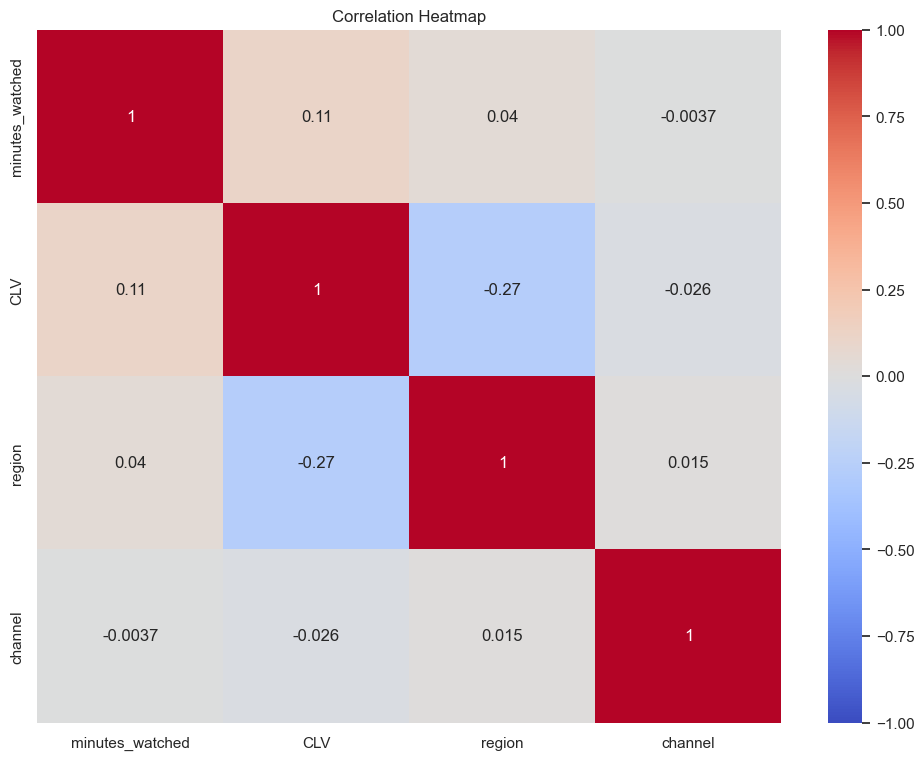

In [24]:
plt.figure(figsize=(12, 9))
sns.heatmap(data = correlation_matrix,
           annot = True,
           cmap = 'coolwarm',
           vmin = -1,
           vmax = 1)
plt.title('Correlation Heatmap')
plt.savefig('corr.png')
plt.show()

This analysis does not reveal strong or positive correlations within the data. Therefore, I employ more sophisticated learning methods to understand the relationship within the data.

### Visualize Raw Data

Create a scatter plot of the two numerical values in our data: `minutes_watched` and `CLV`

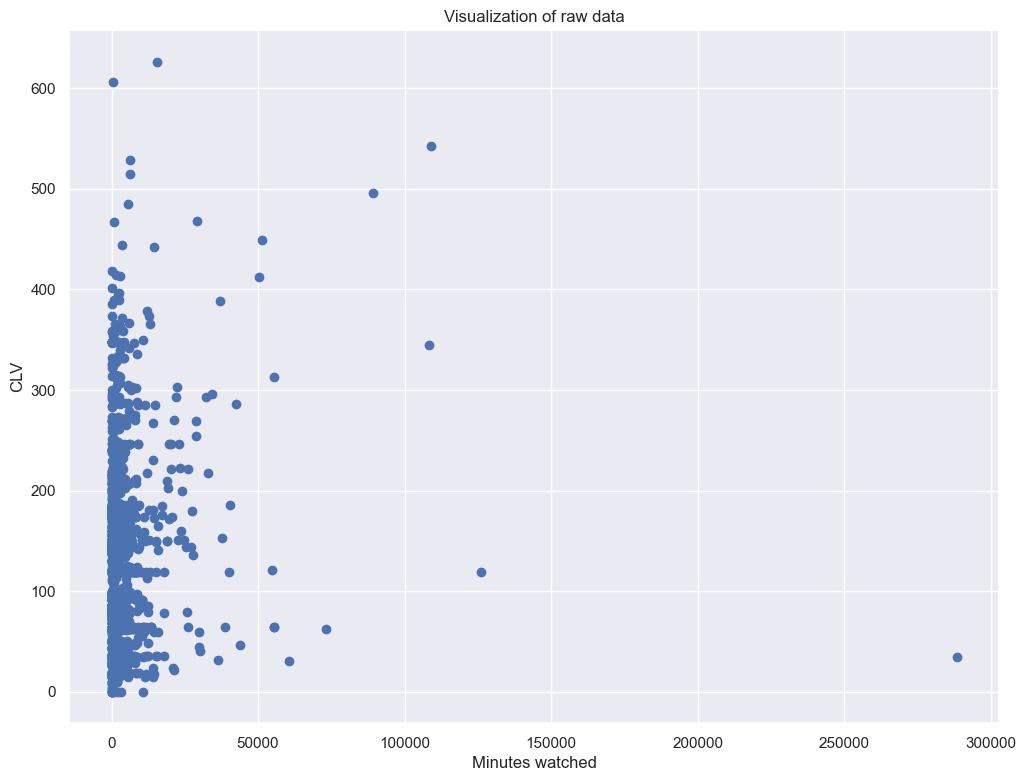

In [26]:
plt.figure(figsize = (12, 9))
plt.scatter(df_segmentation.iloc[:, 0], df_segmentation.iloc[:, 1])
plt.xlabel('Minutes watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data')
plt.savefig('scatter.png')
plt.show()

Minutes_watched vs. CLV plot does not reveal much, apart from noticing a few outliers. Thus, I cannot conclude anything because the scale of the minutes watched vastly differs from that of the CLV. This leaves the chart looking cluttered. A possible solution would be to remove the outliers or rescale the minutes watched to hours watched.

Lastly, this scatter plot serves as an illustrative reminder of a pivotal aspect of our analysis: the importance of uniformly scaling all features to ensure they hold equal weight during segmentation.

## Dummy Variables

To perform a quantitative analysis of the groups, I’ll create dummy variables for the region of countries and the channels - the survey answers. These are categorical answers, so having them as dummy variables makes sense.

In [29]:
# Create a list of the channels of acquisition variable
df_heard_from = df_segmentation['channel']

In [31]:
# Create a list of the geographic regions variable
df_countries = df_segmentation['region']

In [33]:
# Get dummy variables for each unique value in 'channel'
df_dummies = pd.get_dummies(df['channel'].apply(pd.Series).stack())

# Use groupby on index and then sum the results
df_dummies = df_dummies.groupby(level=0).sum()

# Join the dummy variables to original dataframe
df = df.join(df_dummies)

In [34]:
# identical dummies for the channel of aquisition
segment_dummies = pd.get_dummies(df_heard_from, prefix = 'channel', prefix_sep = '_')
df_segmentation = pd.concat([df_segmentation, segment_dummies], axis = 1)

In [35]:
# Creating dummy variables for the `df_countries` dataframe. 
# Each column in `df_countries` will be prefixed with 'country_region_' in the new columns.
segment_dummies_2 = pd.get_dummies(df_countries, prefix = 'country_region', prefix_sep = '_')

# Appending the created dummy columns from `segment_dummies_2` to the `df_segmentation` dataframe.
df_segmentation = pd.concat([df_segmentation, segment_dummies_2], axis = 1)

In [36]:
# drop the channel variable as it is non-numerical and we'll not be able to perform the segmentation
df_segmentation = df_segmentation.drop(["channel"], axis = 1)

In [37]:
df_segmentation

,minutes_watched,CLV,region,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True


In [38]:
# rename the columns after adding the dummie variables
df_segmentation = df_segmentation.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn', 
                                                    'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                                    'country_region_0':'Region_0','country_region_1':'Region_1','country_region_2':'Region_2'})

In [39]:
df_segmentation

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True
